In [5]:
# Softmax function : for details you can refer "https://cs231n.github.io/neural-networks-case-study/"
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]  
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
       
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    # print('after reshaping the data', X_train.shape)
    
    # Normalize the data: subtract the mean image - zero centered the data
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    #print('after Mean subtraction', X_train.shape)
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    # print('after adding bias dimension', X_train.shape)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [7]:
import numpy as np
from random import shuffle

def softmax_loss_naive(W, X, y, reg):
    """
      Softmax loss function, naive implementation (with loops)
      Inputs have dimension D, there are C classes, and we operate on minibatches
      of N examples.
      Inputs:
      - W: A numpy array of shape (D, C) containing weights.
      - X: A numpy array of shape (N, D) containing a minibatch of data.
      - y: A numpy array of shape (N,) containing training labels; y[i] = c means
        that X[i] has label c, where 0 <= c < C.
      - reg: (float) regularization strength
      Returns a tuple of:
      - loss as single float
      - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dw = np.zeros_like(W)
    
    num_examples = X.shape[0]
    num_classes = W.shape[1]
    
    #############################################################################
      # TODO: Compute the softmax loss and its gradient using explicit loops.   #
      # Store the loss in loss and the gradient in dW. If you are not careful     #
      # here, it is easy to run into numeric instability. Don't forget the        #
      # regularization!                                                           #
    #############################################################################
    
    # compute the class score for Softmax Linear Classifier. 
    # Score will be of shape [N x C], where each row gives score for each of the class.
    # scores = X.dot(W)
    scores = np.dot(X, W)
    
    scores = scores - np.max(scores, axis=1)[:, np.newaxis]
    
    # exponentiate score value to get unnormalized probabilities (from unnormalized log probabilities)
    scores = np.exp(scores) 
    
    # Normalize it for each example to get probabilities
    class_prob = scores / np.sum(scores, axis = 1)[:, np.newaxis]
    
    # we’ve normalized them every row now sums to one.
    # We can now query for the log probabilities assigned to the correct classes in each example:
    # true_prob is a 1D array of just the probabilities assigned to the correct classes for each example
    true_prob = class_prob[range(num_examples), y]
    
    # The full loss is then the average of these log probabilities and the regularization loss:
    loss = np.sum(-np.log(true_prob))
    loss /= num_examples
    loss += reg * 0.5 * np.sum(W*W)
    
    # To get the gradient on scores
    dscores = class_prob
    dscores[range(num_examples),y] -=1
    
    # we can now backpropagate into W
    dw = np.dot(X.T, dscores)
    dw /= num_examples
    dw += reg * W
    
    return loss, dw


def softmax_loss_vectorized(W, X, y, reg):
    
    """
      Softmax loss function, vectorized version.
      Inputs and outputs are the same as softmax_loss_naive.
    """
      # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    num_examples = X.shape[0]
    num_classes = W.shape[1]

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
    scores = X.dot(W)
    
    # numeric stability
    scores = scores - np.max(scores, axis = 1)[:,np.newaxis]
    scores = np.exp(scores)
    class_prob = scores / np.sum(scores, axis = 1)[:, np.newaxis]
    true_prob = class_prob[range(num_examples), y]

    class_score = class_prob
    class_score[range(num_examples), y] -= 1

    loss = np.sum(-np.log(true_prob))
    loss /= num_examples
    loss += 0.5 * reg * np.sum(W*W)

    dW = np.dot(X.T, class_score)
    dW /= num_examples
    dW += reg*W

    return loss, dW


In [8]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

#from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.379181
sanity check: 2.302585


In [ ]:

Inline Question 1:

Why do we expect our loss to be close to -log(0.1)?

Answer :- In CIFAR_10 dataset we have 10 classes, so '0.1' that is(1 / 10) probability for each of the class,
          our loss is giving unnormalised negative log probabilities of each class so should be close to -log(0.1)

for details you can refer "https://cs231n.github.io/neural-networks-case-study/"



In [24]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
print('Using REGULARIZATION')
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.996585 analytic: 1.996585, relative error: 1.174277e-08
numerical: -0.117316 analytic: -0.117316, relative error: 1.324594e-08
numerical: 1.002979 analytic: 1.002979, relative error: 5.266668e-08
numerical: -1.232159 analytic: -1.232159, relative error: 3.738965e-09
numerical: 0.232107 analytic: 0.232107, relative error: 6.693531e-08
numerical: 0.326546 analytic: 0.326546, relative error: 6.955588e-08
numerical: -0.590313 analytic: -0.590313, relative error: 3.034818e-08
numerical: -1.352504 analytic: -1.352504, relative error: 4.026869e-08
numerical: -0.553097 analytic: -0.553097, relative error: 3.318105e-08
numerical: 0.052492 analytic: 0.052492, relative error: 5.272460e-07
Using REGULARIZATION
numerical: -0.266938 analytic: -0.266938, relative error: 5.116260e-08
numerical: -0.115467 analytic: -0.115468, relative error: 3.293932e-07
numerical: 0.013130 analytic: 0.013130, relative error: 2.589853e-06
numerical: -1.354314 analytic: -1.354314, relative error: 2.327483e-

In [11]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

#from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.379181e+00 computed in 0.009776s
vectorized loss: 2.379181e+00 computed in 0.008427s
Loss difference: 0.000000
Gradient difference: 0.000000


In [19]:
class Softmax:
    
    def __init__(self, W):
        self.W = W
        
    def train(self, X, y, epochs, lr, batch_size, reg, verbose):
        num_examples = X.shape[0]
        for epoch in range(epochs):
            avg_loss = 0
            for i in range(0,num_examples, batch_size):
                batch_start = i
                batch_end = min(batch_start+batch_size, num_examples)
                x_batch = X[batch_start:batch_end]
                y_batch = y[batch_start:batch_end]
                loss, dW = softmax_loss_vectorized(self.W, x_batch, y_batch, reg)
                avg_loss+=loss
                self.W -= lr*dW
            avg_loss/= math.ceil(num_examples/batch_size)

            if epoch%verbose==0:
                print("Epoch {}, avg loss: {}".format(epoch, avg_loss))
                
    def classify(self, X):
        out = X@self.W
        return out

    def predict(self, X):
        out = X@self.W
        return np.argmax(out, axis=1)

In [20]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
#from cs231n.classifiers.softmax import Softmax, softmax_loss_vectorized
import math
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
from itertools import product
for lr, reg in product(learning_rates, regularization_strengths):
    W = np.random.randn(3073, 10) * 0.0001
    s = Softmax(W)
    s.train(X_train, y_train, 10, lr, 100, 0, 1)
    
    y_train_pred = np.argmax(s.classify(X_train), axis=1)
    train_acc = np.sum(y_train_pred==y_train)/y_train_pred.shape[0]*100
    
    y_val_pred =  np.argmax(s.classify(X_val), axis=1)
    val_acc = np.sum(y_val_pred==y_val)/y_val_pred.shape[0]*100
    
    results[(lr,reg)] = (train_acc,val_acc)
    
    if val_acc>best_val:
        best_val = val_acc
        best_softmax = s
    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Epoch 0, avg loss: 1.9914072766642357
Epoch 1, avg loss: 1.8645374381832829
Epoch 2, avg loss: 1.8262920103955127
Epoch 3, avg loss: 1.8043680357408107
Epoch 4, avg loss: 1.7893110567856254
Epoch 5, avg loss: 1.7779637967676798
Epoch 6, avg loss: 1.7689042058265305
Epoch 7, avg loss: 1.761382481910094
Epoch 8, avg loss: 1.7549611942919636
Epoch 9, avg loss: 1.7493656542499108
Epoch 0, avg loss: 2.012230599400863
Epoch 1, avg loss: 1.8691941080144627
Epoch 2, avg loss: 1.8288389690194526
Epoch 3, avg loss: 1.8060232596594499
Epoch 4, avg loss: 1.7904824948931668
Epoch 5, avg loss: 1.778845258494754
Epoch 6, avg loss: 1.7696004411644626
Epoch 7, avg loss: 1.7619536690466764
Epoch 8, avg loss: 1.7554432088800274
Epoch 9, avg loss: 1.7497805153429424
Epoch 0, avg loss: 1.8706547923945098
Epoch 1, avg loss: 1.7737454873315393
Epoch 2, avg loss: 1.7474599923278749
Epoch 3, avg loss: 1.7317117185423472
Epoch 4, avg loss: 1.7206030730240087
Epoch 5, avg loss: 1.712116541327471
Epoch 6, avg los

In [21]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.409000


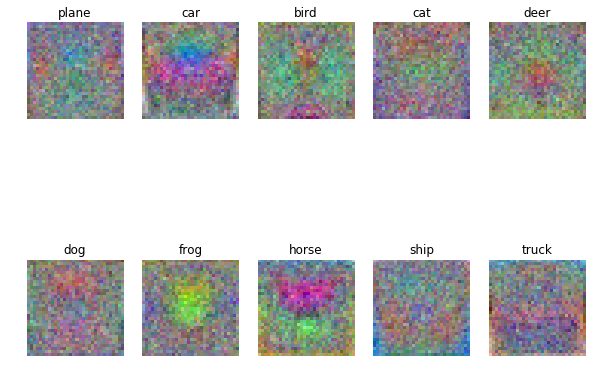

In [22]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])